# Chest X-Ray Pneumonia Detection with Deep Learning
##### By: Zachary Raup


### Introduction

Pneumonia is a severe lung infection and a major global health concern, particularly for children under five, older adults, and immunocompromised individuals. Timely and accurate diagnosis is critical to prevent complications and guide treatment.

This project explores how deep learning can assist in pneumonia detection from chest X-ray images. Specifically, it implements and compares convolutional neural networks (CNNs) to classify radiographs into two categories: **NORMAL** or **PNEUMONIA**. The goal is to support clinical decision-making, reduce diagnostic errors, and offer interpretable AI tools through visual explanation.

Key components of this project include:

- **Model benchmarking** using pretrained CNNs: **ResNet18**, **DenseNet121**, and **EfficientNet-B0**
- **Stratified K-Fold Cross-Validation** to ensure balanced evaluation across classes
- **Grad-CAM interpretability** to visualize regions influencing the model's predictions
- **Ensemble learning** and **early stopping** for performance and generalization
- Thorough performance evaluation using metrics such as **F1-score**, **ROC-AUC**, and **confusion matrix analysis**

This work not only prioritizes model accuracy but also emphasizes interpretability and clinical relevance—key for adoption in medical imaging applications.

### Skills Used
-  **Computer Vision** for Medical Image Classification
-  **PyTorch** Framework with Custom Training Loops
-  **Transfer Learning** from Pretrained CNNs
-  **Stratified K-Fold Cross-Validation** (5-fold)
-  **Performance Metrics**: Accuracy, F1-score, ROC Curve, Confusion Matrix
-  **Grad-CAM** for Model Interpretability
-  **Data Visualization** with Matplotlib & Seaborn
-  **Data Preprocessing & Augmentation**

### About the Dataset

The dataset used is the **Chest X-ray Pneumonia** dataset from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia), consisting of **5,856 chest radiographs** categorized into two classes:

- **NORMAL**: Healthy lungs
- **PNEUMONIA**: Infected lungs (bacterial or viral origin)

The dataset is divided into:

- `train/` — 5,216 images for training
- `val/` — 16 images for validation
- `test/` — 624 images for final evaluation

Initial visualizations in the notebook explore **class imbalance**, **dataset size per split**, and overall distribution, setting the stage for robust training and evaluation.

---

## ***Preproccessing and Analysis***

### Imports, Reproducibility, and Device Configuration
Load all necessary libraries and sets up the runtime environment. Allow for reproducibility by setting random seeds across various libraries and configures the device (GPU if available, otherwise CPU). These steps are critical to ensure consistent results and efficient computation during model training and evaluation.

In [1]:
# Imports
import os  # For interacting with the operating system
import random  # For generating random numbers (seeded for reproducibility)
import numpy as np  # For numerical computations
import torch  # PyTorch core library
import torch.nn as nn  # Neural network layers and loss functions
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image


# PyTorch vision utilities
from torchvision import models, transforms  # Pre-trained models and image transformations
from torchvision.datasets import ImageFolder  # For loading image datasets organized in folders
from torchvision.models import resnet18, densenet121, efficientnet_b0, ResNet18_Weights, DenseNet121_Weights, EfficientNet_B0_Weights

# PyTorch data utilities
from torch.utils.data import DataLoader, Subset, ConcatDataset  # For batching, splitting, and combining datasets

# Scikit-learn utilities for model evaluation and cross-validation
from sklearn.model_selection import StratifiedKFold  # Ensures class balance in cross-validation splits
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, roc_curve, auc)  # Evaluation metrics

from tqdm import tqdm  # Progress bars for training/evaluation loops
from PIL import Image  # Image processing library
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Statistical data visualization
import cv2  # OpenCV for advanced image processing
import warnings  # To suppress warnings during execution

# Ignore warnings to keep notebook output clean
warnings.filterwarnings("ignore")

# Reproducibility: Set a seed to ensure consistent results across runs
SEED = 42
random.seed(SEED)  # Python's built-in RNG
np.random.seed(SEED)  # NumPy's RNG
torch.manual_seed(SEED)  # PyTorch's RNG for CPU
torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
torch.backends.cudnn.benchmark = False  # Disable optimization that may introduce randomness

# Device configuration: Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset paths
DATA_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"  # Root directory containing dataset folders
TRAIN_DIR = os.path.join(DATA_DIR, "train")  # Path to training data
VAL_DIR = os.path.join(DATA_DIR, "val")  # Path to validation data
TEST_DIR = os.path.join(DATA_DIR, "test")  # Path to test data

### Visual Inspection: Sample Chest X-Rays by Class and Dataset Split
To better understand the dataset's visual characteristics, we display one **random sample** **image per class (NORMAL vs. PNEUMONIA)** from each dataset split: **Training, Validation**, and **Test**.

These sample images help highlight the visual differences between healthy lungs and lungs affected by pneumonia:

- **NNORMAL** Chest X-rays usually show:

    - Dark, well-aerated lung fields (indicating air-filled healthy lungs)

    - Clear outlines of the ribs and diaphragm

    - Absence of cloudy or opaque areas in the lungs

- **PNEUMONIA** Chest X-rays often look:

    - Whiter or cloudier in parts of the lungs (due to fluid or infection)
    
    - Blurred or obscured borders around the diaphragm and heart
    
    - Asymmetrical — one lung may appear more opaque or "filled in" than the other

These visual patterns are the same cues radiologists use to diagnose pneumonia. Later, we’ll apply Grad-CAM to see which regions the model focuses on when making predictions — often aligning with these cloudy or abnormal areas.

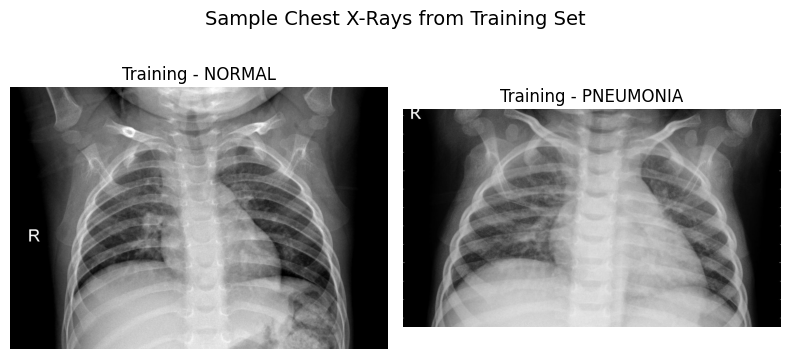

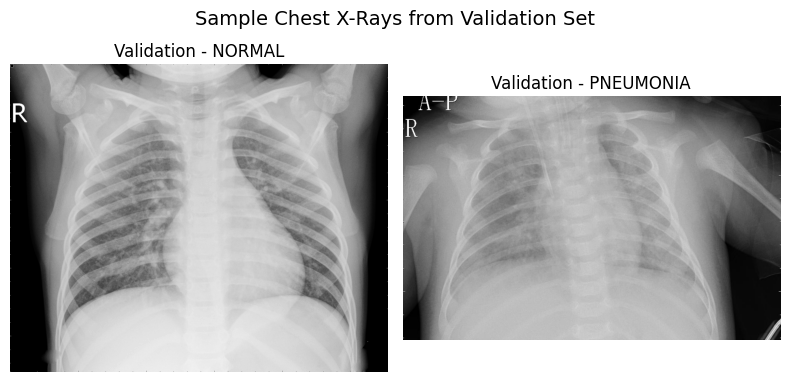

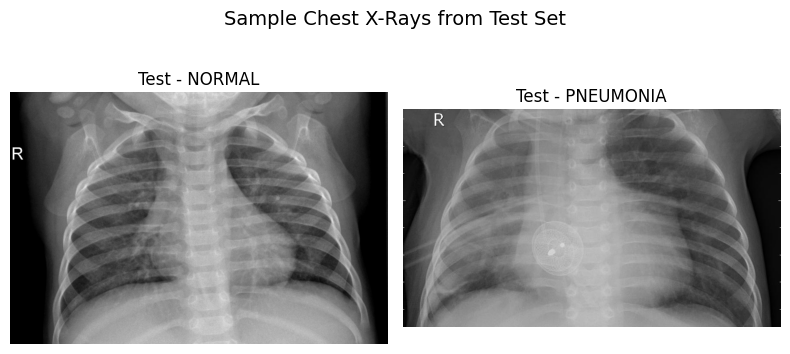

In [2]:
###  Sample Visualization: One Image per Class from Train/Val/Test Sets

def show_sample_images_per_class(base_dir, split_name):
    """
    Displays one sample image per class from a given dataset split.

    Args:
        base_dir (str): Path to the dataset split folder (e.g., TRAIN_DIR).
        split_name (str): Human-readable name of the split ("Train", "Validation", "Test").
    """
    class_names = ["NORMAL", "PNEUMONIA"]
    plt.figure(figsize=(8, 4))
    for idx, class_name in enumerate(class_names):
        # Construct path to class folder
        class_dir = os.path.join(base_dir, class_name)
        image_files = os.listdir(class_dir)
        
        # Randomly select an image from the class
        selected_image = random.choice(image_files)
        image_path = os.path.join(class_dir, selected_image)
        
        # Load and plot image
        image = Image.open(image_path).convert("L")
        plt.subplot(1, 2, idx + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"{split_name} - {class_name}")
        plt.axis("off")
    
    plt.suptitle(f"Sample Chest X-Rays from {split_name} Set", fontsize=14)
    plt.tight_layout()
    plt.show()


# Display a sample NORMAL and PNEUMONIA image from each raw dataset split
show_sample_images_per_class(TRAIN_DIR, "Training")
show_sample_images_per_class(VAL_DIR, "Validation")
show_sample_images_per_class(TEST_DIR, "Test")


#### Analysis of Raw Chest X-ray Images
Before applying any preprocessing, it’s critical to examine the raw chest X-ray images to understand potential challenges and guide model development.

**Key Observations:**
Image Size & Aspect Ratio:
Images come in various resolutions and aspect ratios. Without resizing or padding, this inconsistency can distort lung structures and lead to poor model generalization.

- **Grayscale Format:**
Although stored as RGB, the images are naturally grayscale. Using only one channel reduces memory use and speeds up training without sacrificing diagnostic content.

- **Lighting & Contrast Variability:**
Some images are brighter or more washed out, while others are darker with sharper contrast. These inconsistencies can cause the model to fixate on irrelevant brightness differences rather than actual pathology, especially if normalization isn’t applied.

- **Annotations & Artifacts:**
Labels like “R”, “L”, and visual artifacts (e.g., tubes, wires) may appear in certain classes more often than others. If not addressed, the model might learn to associate these non-medical features with a diagnosis — leading to biased or misleading predictions.

- **Patient Variability:**
The dataset includes pediatric patients, so variations in rib structure, chest size, and positioning are common. This diversity is important, but it also increases the risk of overfitting if the model isn’t trained on a wide enough range of examples.

**Implications for Model Performance:**
Without preprocessing, the model may struggle to learn meaningful patterns and instead rely on spurious correlations (e.g., brightness or text markers).

- **Inconsistent image** sizes can cause convolutional filters to misalign, affecting feature extraction.

- **Unbalanced lighting** and artifacts may inflate performance during training but fail in real-world clinical settings.

- **Proper normalization,** resizing, and data augmentation are necessary to ensure the model focuses on true radiological features — like opacities, lung asymmetry, and tissue density — rather than irrelevant cues.

### Dataset Setup and Image Transformations

Image preprocessing is critical for improving model generalization and maintaining consistency with pretrained CNN architectures. Transformations are applied during data loading as follows:

- **Training Data:**
  - Resized to **224×224** to match input dimensions expected by pretrained models.
  - Converted from grayscale to **3-channel RGB** using a custom transform (`img.convert("RGB")`).
  - Augmented with **random horizontal flips** and **random affine transformations** (±5° rotations, slight translations) to simulate real-world variation in X-rays.
  - Normalized using **ImageNet mean and standard deviation** values to align with pretrained CNN feature distributions.

- **Validation and Test Data:**
  - Subjected only to resizing, channel replication, and normalization—**no data augmentation**—to preserve the integrity of diagnostic features.
  - Optional **center cropping** can be used to suppress edge artifacts, though not applied here.

After preprocessing, the training and validation datasets are merged for use in **Stratified K-Fold Cross-Validation**, ensuring balanced class distribution in each fold and improving model reliability across different subsets.

In [3]:
# Custom transform to replicate grayscale image to 3 channels
to_three_channel = transforms.Lambda(lambda img: img.convert("RGB"))

# Transforms for training data (includes data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    to_three_channel,  # Convert grayscale to 3-channel RGB for pretrained models
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02)),  # Slight rotation + shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet RGB means
                         std=[0.229, 0.224, 0.225])
])

# Transforms for validation and test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    to_three_channel,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_data = ImageFolder(TRAIN_DIR, transform=train_transform)
val_data = ImageFolder(VAL_DIR, transform=test_transform)
test_data = ImageFolder(TEST_DIR, transform=test_transform)

# Combine train and val for K-Fold Cross-Validation
full_train_data = ConcatDataset([train_data, val_data])
full_labels = np.array([sample[1] for sample in train_data] + [sample[1] for sample in val_data])

### Dataset Split & Class Distribution Analysis

Understanding how data is distributed across classes and dataset splits is essential for ensuring reliable model training and evaluation. This section presents two types of visualizations to assess balance:

- **Per-Class Distribution (Pie Charts)**  
  Each of the training, validation, and test sets is analyzed separately to show the proportion of **NORMAL** and **PNEUMONIA** cases. These visualizations help identify potential class imbalances that could impact model performance.

- **Dataset Split Overview**  
  A separate pie chart illustrates how the entire dataset is divided among the three splits: training, validation, and test. This provides a quick summary of the data allocation strategy.

Balanced datasets are crucial for unbiased learning, particularly in medical diagnostics. If any class is underrepresented, strategies such as **data augmentation**, **weighted loss functions**, or **stratified sampling** become essential to mitigate bias and maintain diagnostic sensitivity.


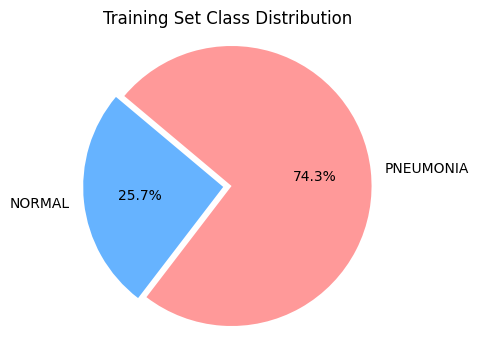

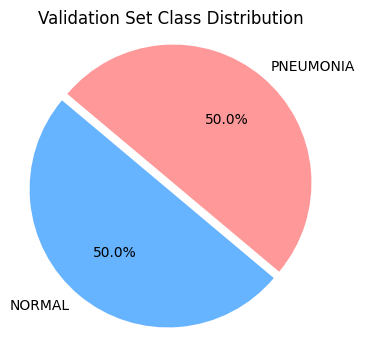

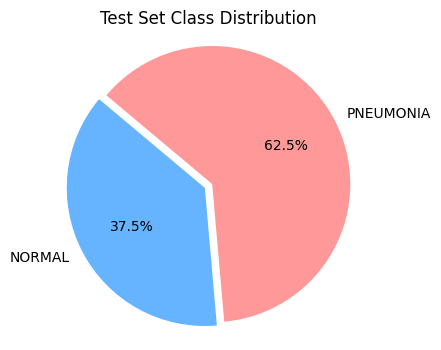

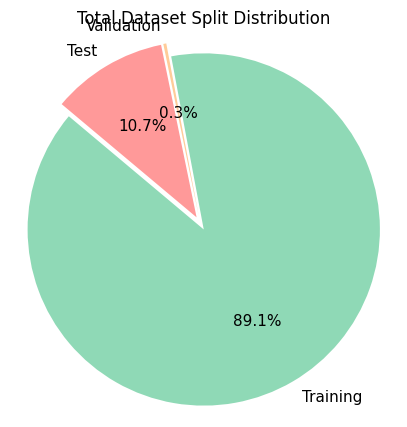

 Dataset Split Summary: {'Training': 5216, 'Validation': 16, 'Test': 624}


In [4]:
###  Dataset Split & Class Distribution Analysis

#  Function to count class samples in a dataset
def count_images_per_class(dataset):
    """
    Counts the number of images per class in a dataset.

    Args:
        dataset (torchvision.datasets.ImageFolder): Dataset object.

    Returns:
        dict: Class name -> count
    """
    class_counts = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts


#  Function to plot pie chart for a single dataset's class distribution
def plot_pie_chart(class_counts, title):
    """
    Plots a pie chart for class distribution.

    Args:
        class_counts (dict): Class name -> count
        title (str): Chart title
    """
    labels = list(class_counts.keys())
    sizes = list(class_counts.values())
    colors = ['#66b3ff', '#ff9999']  # Blue: NORMAL, Red: PNEUMONIA
    explode = (0.03, 0.03)  # Slight separation for visual clarity

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
            colors=colors, explode=explode, textprops={'fontsize': 10})
    plt.title(title, fontsize=12)
    plt.axis('equal')
    plt.show()


#  Class Distributions (Per Split)
train_counts = count_images_per_class(train_data)
val_counts = count_images_per_class(val_data)
test_counts = count_images_per_class(test_data)

# Visualize class distributions
plot_pie_chart(train_counts, "Training Set Class Distribution")
plot_pie_chart(val_counts, "Validation Set Class Distribution")
plot_pie_chart(test_counts, "Test Set Class Distribution")


### Total Split Distribution Pie Chart

#  Total image counts by split
total_counts = {
    "Training": len(train_data),
    "Validation": len(val_data),
    "Test": len(test_data)
}

#  Visualizing total image allocation across splits
plt.figure(figsize=(5, 5))
colors = ['#8fd9b6', '#ffcc99', '#ff9999']
explode = (0.04, 0.04, 0.04)

plt.pie(total_counts.values(),
        labels=total_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        explode=explode,
        textprops={'fontsize': 11})

plt.title("Total Dataset Split Distribution", fontsize=12)
plt.axis('equal')
plt.show()

# Print numerical summary
print(" Dataset Split Summary:", total_counts)

#### Analysis of Data Distribution

A well-structured and representative dataset is essential for building robust deep learning models — especially in medical imaging, where imbalances can lead to biased or clinically unsafe predictions.

**Strengths**:

- The **training set is large (5,216 images)**, providing sufficient samples for model learning.

- All three splits include **both classes (NORMAL and PNEUMONIA)**, preventing the model from overfitting to one class during training or evaluation.

- The **test set’s class distribution (≈62.5% PNEUMONIA)** mirrors real-world clinical prevalence, which helps evaluate the model under realistic conditions.

 **Potential Issues**:

- The **validation set is extremely small (only 16 images total**) — too limited to provide meaningful signals for tuning hyperparameters or applying early stopping.

- The training set is imbalanced (**~3:1 PNEUMONIA:NORMAL**). This risks the model overpredicting the majority class, especially when optimizing only for accuracy.

- The **test set is also skewed**, which could mask poor model sensitivity toward the underrepresented class.

**Mitigations to Be Taken**:

- **Stratified K-Fold Cross-Validation** helps maintain class balance across training and validation folds, improving the reliability of performance estimates.

- **Use class-aware metrics** like F1-score, Precision, Recall, and AUC to evaluate model performance, especially for detecting underrepresented **NORMAL** cases.

- **Class-balanced training** is implemented using nn.CrossEntropyLoss(weight=class_weights), which penalizes errors on the minority class more heavily. This helps mitigate the 3:1 class imbalance during training and improves recall and F1-score for the NORMAL class.

- **Grad-CAM visualizations** will help verify that the model is learning from clinically meaningful features — not from dataset artifacts or noise.

---

## ***Build Deep Learning Models***

### Model Loader Function

The `get_model()` utility initializes one of three supported convolutional neural networks for binary classification of chest X-rays: **ResNet18**, **DenseNet121**, or **EfficientNet-B0**. Each model can be loaded with pretrained ImageNet weights and modified to output predictions for two classes: *Normal* and *Pneumonia*.

**Function:** `get_model(model_name, pretrained=True)`

**Highlights:**

- Flexible architecture selection: `'resnet18'`, `'densenet121'`, `'efficientnet_b0'`
- Option to load pretrained weights for faster convergence
- Final classification layer replaced with a 2-output linear layer
- Model returned on the appropriate device (`CPU` or `GPU`)

This modular design supports rapid experimentation across architectures while maintaining a consistent interface.

In [5]:
def get_model(model_name, pretrained=True):
    """
    Returns a specified CNN model architecture initialized with or without pretrained weights.

    Args:
        model_name (str): Name of the architecture ('resnet18', 'densenet121', 'efficientnet_b0').
        pretrained (bool): Whether to use pretrained ImageNet weights.

    Returns:
        torch.nn.Module: Initialized model ready for training or inference.
    """
    if model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == "densenet121":
        model = models.densenet121(pretrained=pretrained)
        model.classifier = nn.Linear(model.classifier.in_features, 2)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")

    return model.to(device)


### Training and Evaluation Utilities

Two core utility functions are defined to streamline model validation and prediction in the binary classification task:

- **`evaluate(model, loader)`**  
  Computes standard performance metrics on a validation or test set. Returns a dictionary containing:

  - **Accuracy**: Overall proportion of correct predictions.
  - **F1 Score**: Harmonic mean of precision and recall, useful for imbalanced data.
  - **Precision**: Proportion of predicted *Pneumonia* cases that are correct.
  - **Recall**: Proportion of actual *Pneumonia* cases correctly identified.
  - **Classification Report**: Detailed per-class metrics including support.

- **`evaluate_predictions(model, loader)`**  
  Outputs the predicted class labels for each sample in the dataset. This is particularly useful for generating ensemble predictions or final submission files, without computing evaluation metrics.

These functions support consistent model evaluation across K-Fold folds and final testing.


In [6]:
def evaluate(model, loader):
    """
    Evaluate model performance on a given dataset loader.
    Returns a dictionary with multiple performance metrics.
    """
    model.eval()  # Set model to evaluation mode
    preds, targets = [], []  # Initialize prediction and ground-truth storage

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for x, y in loader:
            x = x.to(device)  # Move input to device
            out = model(x)  # Forward pass
            preds.extend(out.argmax(1).cpu().tolist())  # Get predicted class labels
            targets.extend(y.tolist())  # Store true labels

    # Return evaluation metrics
    return {
        "acc": accuracy_score(targets, preds),  # Accuracy
        "f1": f1_score(targets, preds, zero_division=0),  # F1 Score
        "precision": precision_score(targets, preds),  # Precision
        "recall": recall_score(targets, preds),  # Recall
        "report": classification_report(
            targets, preds,
            target_names=["Normal", "Pneumonia"],
            output_dict=True  # Return report as a dictionary
        )
    }

def evaluate_predictions(model, loader):
    """
    Return predicted class labels for the entire dataset without computing metrics.
    Useful for ensemble predictions or submission generation.
    """
    model.eval()
    preds = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)  # Move input to device
            out = model(x)  # Forward pass
            preds += out.argmax(1).cpu().tolist()  # Get class predictions

    return preds


### K-Fold Cross-Validation Training Loop
This section defines `train_kfold()`, a function that performs **Stratified K-Fold Cross-Validation** for model training and evaluation. It supports **early stopping, class-weighted loss, and per-fold model saving** based on F1 score thresholds.

**Key Features:**

- Uses `StratifiedKFold` to preserve class distribution across folds

- Applies `nn.CrossEntropyLoss(weight=class_weights)` to address class imbalance

- Saves models exceeding an F1 threshold (`f1_threshold`)

- Displays per-epoch training progress using `tqdm`

- Applies early stopping based on validation F1 score plateau

In [7]:
k_split = 3 # Set Number of Training Splits
epoch_num = 10 # Set Number of Training Epochs

def train_kfold(model_name, k=k_split, f1_threshold=0.90, max_epochs=epoch_num, patience=4):
    """
    Train a given model using Stratified K-Fold cross-validation.
    Saves models with F1 score above threshold and returns paths and fold results.
    
    Args:
        model_name (str): Name of the model to train (resnet18, densenet121, efficientnet_b0).
        k (int): Number of folds.
        f1_threshold (float): Minimum F1 score to save the model.
        max_epochs (int): Max number of epochs per fold.
        patience (int): Early stopping patience.
    
    Returns:
        best_models (List[str]): Paths to the best saved models.
        fold_results (List[float]): F1 scores from each fold.
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)  # Create stratified K-fold splitter
    fold_results = []  # Store F1 score from each fold
    best_models = []   # Store paths of saved models
    
    # Count class distribution in full training data
    label_tensor = torch.tensor(full_labels)
    class_sample_counts = torch.bincount(label_tensor)
    
    # Inverse frequency for weights (can also use sklearn's compute_class_weight if needed)
    class_weights = 1.0 / class_sample_counts.float()
    class_weights = class_weights / class_weights.sum()  # Normalize to sum to 1
    class_weights = class_weights.to(device)


    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(full_labels)), full_labels)):
        print(f"\n--- Fold {fold + 1} ---")

        # Create dataloaders for the current fold
        train_subset = Subset(full_train_data, train_idx)
        val_subset = Subset(full_train_data, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32)

        # Initialize model, optimizer, and loss function
        model = get_model(model_name)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        best_f1 = 0
        patience_counter = 0
        best_state = None

        for epoch in range(max_epochs):
            # Training loop with tqdm progress bar
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1} [Fold {fold+1}]", leave=False)

            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                # Update progress bar
                loop.set_postfix(loss=running_loss / total, acc=correct / total)

            # Evaluate on validation set
            metrics = evaluate(model, val_loader)
            print(f"Epoch {epoch+1} | Val Acc: {metrics['acc']:.4f}, F1: {metrics['f1']:.4f}")

            # Check if current model is best so far
            if metrics["f1"] > best_f1:
                best_f1 = metrics["f1"]
                best_state = model.state_dict()  # Save best model weights
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break  # Stop training early if no improvement

        # Save the best model for this fold if F1 exceeds threshold
        if best_f1 >= f1_threshold:
            save_path = f"{model_name}_fold{fold}_f1{best_f1:.4f}.pt"
            torch.save(best_state, save_path)
            print(f"✅ Saved best model to {save_path}")
            best_models.append(save_path)
        else:
            print("Fold discarded due to low F1")

        # Store best F1 score from this fold
        fold_results.append(best_f1)

    return best_models, fold_results

### Evaluate Best Models on the Test Set

This section defines the `evaluate_on_test()` function, which performs the following:

- **Loads** each saved model from the Stratified K-Fold training phase  
- **Evaluates** the model on the held-out **test dataset**  
- **Calculates key metrics**, including **accuracy**, **F1-score**, and a detailed **classification report** with per-class precision and recall  
- **Returns** a summary of evaluation results for downstream comparison and visualization

This evaluation step is essential for assessing the **generalization capability** of each model on completely unseen data, ensuring that performance metrics are not biased by validation folds.


In [18]:
def evaluate_on_test(model_paths, model_name):
    """
    Evaluate saved models on the test set and print performance metrics.
    
    Args:
        model_paths (list): List of file paths to the saved model .pt files.
        model_name (str): Name of the model architecture to load (e.g., resnet18).
    
    Returns:
        results (list of dict): Contains accuracy and F1-score for each model.
    """
    test_loader = DataLoader(test_data, batch_size=32)  # DataLoader for test set
    results = []  # Store evaluation metrics for each model

    for path in model_paths:
        # Load model and weights
        model = get_model(model_name)
        model.load_state_dict(torch.load(path, map_location=device))  # Load model weights
        model.to(device)

        # Evaluate using helper function
        metrics = evaluate(model, test_loader)

        # Print performance summary
        print(f"\n📁 Model: {path}")
        print(f"Accuracy: {metrics['acc']:.4f}, F1: {metrics['f1']:.4f}")
        
        # Collect true and predicted labels
        y_true, y_pred = [], []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
        
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
        
        # Print the classification report
        print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


        # Append metrics to results list
        results.append({
            "path": path,
            "acc": metrics["acc"],
            "f1": metrics["f1"]
        })

    return results

#### Train Models with Stratified K-Fold Cross-Validation

Three convolutional neural networks—**ResNet18**, **DenseNet121**, and **EfficientNet-B0**—are trained using **Stratified K-Fold Cross-Validation** to ensure each fold maintains balanced representation of both NORMAL and PNEUMONIA classes. This validation strategy improves robustness and mitigates class imbalance bias.

##### **Key Strategy**

- Training is repeated across *k* folds (**default: k = 3**)
- Only models achieving an **F1-score above a defined threshold** are retained
- Underperforming models are filtered out before ensemble creation

This pipeline ensures that only the most generalizable models contribute to the final ensemble, improving stability and accuracy.

##### **Model Architectures**

- **ResNet18**  
  A lightweight convolutional neural network that introduces residual connections to mitigate vanishing gradients and improve training stability in deeper networks. Its simplicity and efficiency make it a strong baseline for medical image classification tasks.

- **DenseNet121**  
  A densely connected architecture where each layer receives inputs from all preceding layers, promoting feature reuse and improving gradient flow. This design leads to compact models with high representational capacity, well-suited for complex visual patterns in radiographic data.

- **EfficientNet-B0**  
  A highly optimized model architecture that employs compound scaling to uniformly scale depth, width, and resolution. It achieves excellent performance with fewer parameters and lower computational cost, making it ideal for scalable medical AI applications.


In [9]:
# Train ResNet18 models using stratified K-Fold and save top-performing models
resnet_models, _ = train_kfold("resnet18")

# Train DenseNet121 models using stratified K-Fold and save top-performing models
densenet_models, _ = train_kfold("densenet121")

# Train EfficientNet-B0 models using stratified K-Fold and save top-performing models
efficientnet_models, _ = train_kfold("efficientnet_b0")


--- Fold 1 ---


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Epoch 1 | Val Acc: 0.9805, F1: 0.9869


Epoch 2 | Val Acc: 0.9822, F1: 0.9879


Epoch 3 | Val Acc: 0.9862, F1: 0.9907


Epoch 4 | Val Acc: 0.9679, F1: 0.9781


Epoch 5 | Val Acc: 0.9845, F1: 0.9895


Epoch 6 | Val Acc: 0.9857, F1: 0.9904


Epoch 7 | Val Acc: 0.9880, F1: 0.9919


Epoch 8 | Val Acc: 0.9874, F1: 0.9915


Epoch 9 | Val Acc: 0.9811, F1: 0.9871


Epoch 10 | Val Acc: 0.9782, F1: 0.9851
✅ Saved best model to resnet18_fold0_f10.9919.pt

--- Fold 2 ---


Epoch 1 | Val Acc: 0.9478, F1: 0.9636


Epoch 2 | Val Acc: 0.9759, F1: 0.9839


Epoch 3 | Val Acc: 0.9834, F1: 0.9887


Epoch 4 | Val Acc: 0.9874, F1: 0.9915


Epoch 5 | Val Acc: 0.9851, F1: 0.9899


Epoch 6 | Val Acc: 0.9880, F1: 0.9918


Epoch 7 | Val Acc: 0.9696, F1: 0.9791


Epoch 8 | Val Acc: 0.9805, F1: 0.9867


Epoch 9 | Val Acc: 0.9834, F1: 0.9888


Epoch 10 | Val Acc: 0.9851, F1: 0.9899
Early stopping
✅ Saved best model to resnet18_fold1_f10.9918.pt

--- Fold 3 ---


Epoch 1 | Val Acc: 0.9759, F1: 0.9838


Epoch 2 | Val Acc: 0.9742, F1: 0.9827


Epoch 3 | Val Acc: 0.9794, F1: 0.9861


Epoch 4 | Val Acc: 0.9765, F1: 0.9841


Epoch 5 | Val Acc: 0.9799, F1: 0.9865


Epoch 6 | Val Acc: 0.9822, F1: 0.9880


Epoch 7 | Val Acc: 0.9805, F1: 0.9868


Epoch 8 | Val Acc: 0.9817, F1: 0.9877


Epoch 9 | Val Acc: 0.9834, F1: 0.9888


Epoch 10 | Val Acc: 0.8974, F1: 0.9353
✅ Saved best model to resnet18_fold2_f10.9888.pt

--- Fold 1 ---


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 205MB/s]


Epoch 1 | Val Acc: 0.9788, F1: 0.9859


Epoch 2 | Val Acc: 0.9845, F1: 0.9895


Epoch 3 | Val Acc: 0.9862, F1: 0.9907


Epoch 4 | Val Acc: 0.9897, F1: 0.9931


Epoch 5 | Val Acc: 0.9862, F1: 0.9907


Epoch 6 | Val Acc: 0.9891, F1: 0.9926


Epoch 7 | Val Acc: 0.9885, F1: 0.9922


Epoch 8 | Val Acc: 0.9908, F1: 0.9938


Epoch 9 | Val Acc: 0.9891, F1: 0.9926


Epoch 10 | Val Acc: 0.9931, F1: 0.9954
✅ Saved best model to densenet121_fold0_f10.9954.pt

--- Fold 2 ---


Epoch 1 | Val Acc: 0.9731, F1: 0.9815


Epoch 2 | Val Acc: 0.9874, F1: 0.9915


Epoch 3 | Val Acc: 0.9811, F1: 0.9872


Epoch 4 | Val Acc: 0.9771, F1: 0.9847


Epoch 5 | Val Acc: 0.9880, F1: 0.9919


Epoch 6 | Val Acc: 0.9817, F1: 0.9875


Epoch 7 | Val Acc: 0.9799, F1: 0.9866


Epoch 8 | Val Acc: 0.9776, F1: 0.9847


Epoch 9 | Val Acc: 0.9908, F1: 0.9938


Epoch 10 | Val Acc: 0.9845, F1: 0.9895
✅ Saved best model to densenet121_fold1_f10.9938.pt

--- Fold 3 ---


Epoch 1 | Val Acc: 0.9748, F1: 0.9829


Epoch 2 | Val Acc: 0.9690, F1: 0.9796


Epoch 3 | Val Acc: 0.9874, F1: 0.9915


Epoch 4 | Val Acc: 0.9811, F1: 0.9872


Epoch 5 | Val Acc: 0.9696, F1: 0.9792


Epoch 6 | Val Acc: 0.9822, F1: 0.9879


Epoch 7 | Val Acc: 0.9811, F1: 0.9872
Early stopping
✅ Saved best model to densenet121_fold2_f10.9915.pt

--- Fold 1 ---


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]


Epoch 1 | Val Acc: 0.9822, F1: 0.9880


Epoch 2 | Val Acc: 0.9748, F1: 0.9828


Epoch 3 | Val Acc: 0.9857, F1: 0.9903


Epoch 4 | Val Acc: 0.9839, F1: 0.9891


Epoch 5 | Val Acc: 0.9914, F1: 0.9942


Epoch 6 | Val Acc: 0.9874, F1: 0.9915


Epoch 7 | Val Acc: 0.9914, F1: 0.9942


Epoch 8 | Val Acc: 0.9897, F1: 0.9930


Epoch 9 | Val Acc: 0.9885, F1: 0.9923


Epoch 10 | Val Acc: 0.9891, F1: 0.9926
✅ Saved best model to efficientnet_b0_fold0_f10.9942.pt

--- Fold 2 ---


Epoch 1 | Val Acc: 0.9673, F1: 0.9777


Epoch 2 | Val Acc: 0.9799, F1: 0.9865


Epoch 3 | Val Acc: 0.9776, F1: 0.9849


Epoch 4 | Val Acc: 0.9799, F1: 0.9864


Epoch 5 | Val Acc: 0.9874, F1: 0.9915


Epoch 6 | Val Acc: 0.9839, F1: 0.9891


Epoch 7 | Val Acc: 0.9845, F1: 0.9896


Epoch 8 | Val Acc: 0.9845, F1: 0.9896


Epoch 9 | Val Acc: 0.9891, F1: 0.9926


Epoch 10 | Val Acc: 0.9805, F1: 0.9868
✅ Saved best model to efficientnet_b0_fold1_f10.9926.pt

--- Fold 3 ---


Epoch 1 | Val Acc: 0.9622, F1: 0.9740


Epoch 2 | Val Acc: 0.9708, F1: 0.9801


Epoch 3 | Val Acc: 0.9799, F1: 0.9865


Epoch 4 | Val Acc: 0.9776, F1: 0.9848


Epoch 5 | Val Acc: 0.9834, F1: 0.9888


Epoch 6 | Val Acc: 0.9782, F1: 0.9852


Epoch 7 | Val Acc: 0.9748, F1: 0.9828


Epoch 8 | Val Acc: 0.9868, F1: 0.9911


Epoch 9 | Val Acc: 0.9834, F1: 0.9888


Epoch 10 | Val Acc: 0.9776, F1: 0.9847
✅ Saved best model to efficientnet_b0_fold2_f10.9911.pt


---

## ***Model Performance***

### Model Evaluation on Test Set

This section assesses the generalization performance of all **top-performing models** retained during Stratified K-Fold training. Each saved model—across ResNet18, DenseNet121, and EfficientNet-B0—is evaluated on the **held-out test dataset**, which was not used during training or validation.

Key evaluation metrics include:

- **Accuracy** – Overall correctness of the predictions.
- **F1-score** – Harmonic mean of precision and recall, particularly important for imbalanced data.

The evaluation results are aggregated and stored to support further analysis, performance comparisons, and the construction of an ensemble model.



In [10]:
# Evaluate ResNet18 models on the test dataset and collect performance metrics
resnet_results = evaluate_on_test(resnet_models, "resnet18")

# Evaluate DenseNet121 models on the test dataset and collect performance metrics
densenet_results = evaluate_on_test(densenet_models, "densenet121")

# Evaluate EfficientNet-B0 models on the test dataset and collect performance metrics
efficientnet_results = evaluate_on_test(efficientnet_models, "efficientnet_b0")


📁 Model: resnet18_fold0_f10.9919.pt
Accuracy: 0.9119, F1: 0.9332
              precision    recall  f1-score   support

      Normal       0.97      0.79      0.87       234
   Pneumonia       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624


📁 Model: resnet18_fold1_f10.9918.pt
Accuracy: 0.8670, F1: 0.9027
              precision    recall  f1-score   support

      Normal       0.97      0.67      0.79       234
   Pneumonia       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624


📁 Model: resnet18_fold2_f10.9888.pt
Accuracy: 0.6971, F1: 0.8050
              precision    recall  f1-score   support

      Normal       1.00      0.19      0.32       234
   Pneumonia       0.67      1.00      

### Analysis of Model Performance on Test Set

Top-performing models from each architecture—**ResNet18**, **DenseNet121**, and **EfficientNet-B0**—were evaluated on the held-out test set *(n = 624)*. The tables below summarize classification performance across three cross-validation folds using metrics such as accuracy, F1-score, and class-wise recall.



#### ResNet18

| Fold | Accuracy | F1-Score | Normal Recall | Pneumonia Recall |
|------|----------|----------|----------------|-------------------|
| 0    | 91.2%    | 0.9332   | 0.79           | 0.98              |
| 1    | 86.7%    | 0.9027   | 0.67           | 0.99              |
| 2    | 69.7%    | 0.8050   | 0.19           | 1.00              |

- **Strengths:** High recall for Pneumonia across all folds, minimizing false negatives.
- **Weaknesses:** Performance in fold 2 degrades due to extremely low recall for the Normal class, indicating overprediction of Pneumonia.
- **Clinical Suitability:** Well-suited for applications prioritizing Pneumonia detection, although results are less reliable when misclassifying Normal cases is costly.



#### DenseNet121

| Fold | Accuracy | F1-Score | Normal Recall | Pneumonia Recall |
|------|----------|----------|----------------|-------------------|
| 0    | 83.2%    | 0.8811   | 0.56           | 1.00              |
| 1    | 89.3%    | 0.9205   | 0.72           | 0.99              |
| 2    | 88.8%    | 0.9165   | 0.73           | 0.98              |

- **Strengths:** Delivers consistently high recall for Pneumonia, with improved Normal recall in later folds.
- **Weaknesses:** Lower recall for Normal in fold 0 (0.56) results in potential overdiagnosis.
- **Clinical Suitability:** Balances Pneumonia sensitivity with improved specificity across folds, offering reliability in diverse clinical settings.



#### EfficientNet-B0

| Fold | Accuracy | F1-Score | Normal Recall | Pneumonia Recall |
|------|----------|----------|----------------|-------------------|
| 0    | 83.8%    | 0.8848   | 0.58           | 0.99              |
| 1    | 89.1%    | 0.9196   | 0.71           | 1.00              |
| 2    | 88.8%    | 0.9169   | 0.72           | 0.99              |

- **Strengths:** Consistently strong performance across all folds with high Pneumonia recall.
- **Weaknesses:** Recall for Normal class remains moderate, particularly in fold 0.
- **Clinical Suitability:** Demonstrates general robustness and effective trade-offs between sensitivity and specificity, suitable for real-world deployment.



#### Summary & Insights

- **Top Performer:** `resnet18_fold0` achieved the highest overall F1-score (0.9332) and accuracy (91.2%), indicating excellent precision–recall trade-off.
- **Most Consistent Model:** **DenseNet121** offers stable, high-level performance with fewer extreme variances in recall across both classes.
- **Clinical Implication:** All architectures exhibit strong Pneumonia sensitivity, which is critical for early and accurate diagnosis. DenseNet121 and EfficientNet-B0 provide strong overall reliability, while ResNet18 shows potential for high performance with better calibration on Normal cases.


### Select Top Models and Print Detailed Classification Reports

In this stage, evaluation results from all saved models across the three architectures are consolidated. The following steps are performed:

- **Aggregate performance metrics** from each architecture.
- Identify the **highest-performing models**:
  - One with the **best F1-score**
  - One with the **highest accuracy**
- Ensure **distinct models** are selected (no duplicates).
- Load each selected model and run inference on the **unseen test set**.
- Generate and print a detailed **classification report**, including:
  - **Per-class precision**
  - **Recall**
  - **F1-score**

This final analysis provides a comprehensive view of how the top models perform on both **NORMAL** and **PNEUMONIA** classes, highlighting their diagnostic strengths and potential weaknesses.


In [11]:
# Define class labels for reporting
class_names = ['NORMAL', 'PNEUMONIA']

# Create DataLoader for test data without shuffling (to preserve order)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Combine evaluation results from all model architectures
all_results = resnet_results + densenet_results + efficientnet_results

# Select model with the highest F1-score
best_by_f1 = max(all_results, key=lambda x: x["f1"])

# Select model with the highest Accuracy
best_by_acc = max(all_results, key=lambda x: x["acc"])

# Get unique model paths from both selections to avoid duplicates
unique_models = {best_by_f1["path"], best_by_acc["path"]}

# Print info and classification report for each selected best model
print("\n✅ Selected Models for Final Analysis:")
for path in unique_models:
    print(f"- {path}")

    if "resnet18" in path:
        model_name = "resnet18"
    elif "densenet121" in path:
        model_name = "densenet121"
    elif "efficientnet_b0" in path:
        model_name = "efficientnet_b0"
    else:
        raise ValueError(f"Cannot identify model architecture from path: {path}")

    # Load the model architecture and weights
    model = get_model(model_name)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()  # Set to evaluation mode

    y_true, y_pred = [], []  # Lists to hold true and predicted labels

    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Accumulate true and predicted labels
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print detailed classification report for the current model
    print(f"\n📊 Classification Report for: {path}")
    print(classification_report(y_true, y_pred, target_names=class_names))


✅ Selected Models for Final Analysis:
- resnet18_fold0_f10.9919.pt

📊 Classification Report for: resnet18_fold0_f10.9919.pt
              precision    recall  f1-score   support

      NORMAL       0.97      0.79      0.87       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



### Detailed Model Analysis: Confusion Matrix, ROC Curve, and Grad-CAM Visualizations

This section offers a comprehensive evaluation of the top-performing models using both quantitative metrics and visual interpretability tools:

- **Confusion Matrix**  
  Presents the number of true positives, false positives, true negatives, and false negatives—allowing a direct assessment of the model’s classification performance for both **NORMAL** and **PNEUMONIA** cases.

- **ROC Curve and AUC (Area Under the Curve)**  
  Illustrates the trade-off between **true positive rate** (sensitivity) and **false positive rate** across thresholds. A higher AUC indicates stronger discriminative capability.

- **Grad-CAM (Gradient-weighted Class Activation Mapping)**  
  Highlights the image regions that most influenced the model’s decision. These heatmaps offer **visual interpretability**, helping to validate that the model is focusing on medically relevant areas of the chest X-rays.

> Together, these tools provide a balanced evaluation of performance, robustness, and clinical relevance—critical for assessing deployment readiness in real-world settings.


In [12]:
# Define Confusion Matrix Function for the best preforming test model
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plots a confusion matrix using seaborn heatmap.
    
    Args:
        y_true (list): Ground truth labels.
        y_pred (list): Predicted labels.
        class_names (list): List of class names for axis labels.
        title (str): Title for the confusion matrix plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [13]:
# Define ROC curve Function for the best preforming test model

def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    """
    Plots an ROC curve for binary classification.
    
    Args:
        y_true (list): Ground truth binary labels (0 or 1).
        y_probs (list): Predicted probabilities for the positive class.
        title (str): Title of the ROC curve plot.
    """
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
# Define Grad-CAM  Function for the best preforming test model
def generate_gradcam(model, input_tensor, target_class, final_conv_layer):
    """
    Generate a Grad-CAM heatmap for a single image.

    Args:
        model (nn.Module): Trained model.
        input_tensor (Tensor): Image tensor (C, H, W) normalized.
        target_class (int): Class index to generate Grad-CAM for.
        final_conv_layer (nn.Module): Last convolutional layer.

    Returns:
        cam (np.ndarray): Grad-CAM heatmap resized to (H, W).
        pred_class (int): Predicted class.
    """
    model.eval()
    gradients, activations = [], []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Register hooks
    f_handle = final_conv_layer.register_forward_hook(forward_hook)
    b_handle = final_conv_layer.register_backward_hook(backward_hook)

    # Forward pass
    input_batch = input_tensor.unsqueeze(0).to(device)
    output = model(input_batch)
    pred_class = output.argmax(dim=1).item()

    # Backprop for target class
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    # Get the gradients and activations
    grads = gradients[0]      # [B, C, H, W]
    acts = activations[0]     # [B, C, H, W]

    # Global average pooling on gradients
    weights = grads.mean(dim=(2, 3), keepdim=True)  # [B, C, 1, 1]
    cam = (weights * acts).sum(dim=1).squeeze()     # [H, W]

    cam = F.relu(cam)
    cam = cam.cpu().numpy()
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)  # Avoid division by zero

    # Resize to original image size
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize((input_tensor.shape[2], input_tensor.shape[1]), resample=Image.BILINEAR)
    cam = np.array(cam) / 255.0

    # Remove hooks
    f_handle.remove()
    b_handle.remove()

    return cam, pred_class

def visualize_gradcam(input_tensor, cam, title="Grad-CAM", alpha=0.4):
    """
    Overlay Grad-CAM on input image.

    Args:
        input_tensor (Tensor): Original image (C, H, W), not normalized.
        cam (np.ndarray): Grad-CAM heatmap (H, W), values in [0, 1].
        title (str): Plot title.
        alpha (float): Heatmap transparency level.
    """
    # Convert input_tensor to RGB numpy image
    img = input_tensor.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # (H, W, C)
    img -= img.min()
    img /= img.max()

    # Use matplotlib to apply colormap
    heatmap = plt.get_cmap("jet")(cam)
    heatmap = np.delete(heatmap, 3, axis=2)  # Remove alpha channel

    # Blend heatmap and image
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = np.clip(overlay, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()



🔍 Analyzing: resnet18_fold0_f10.9919.pt


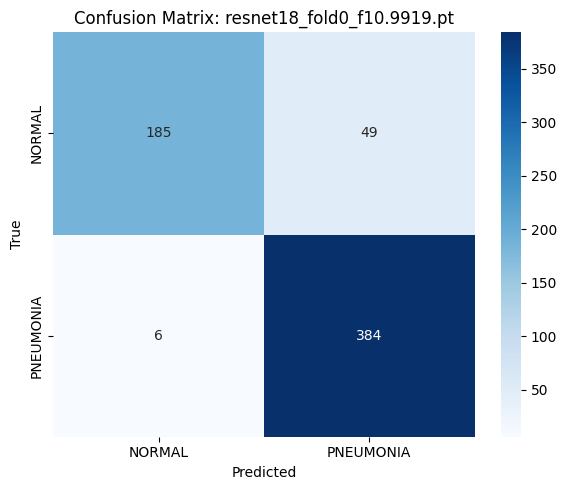

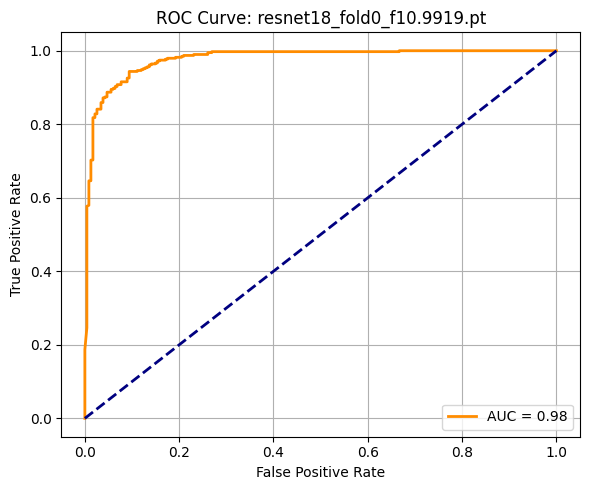

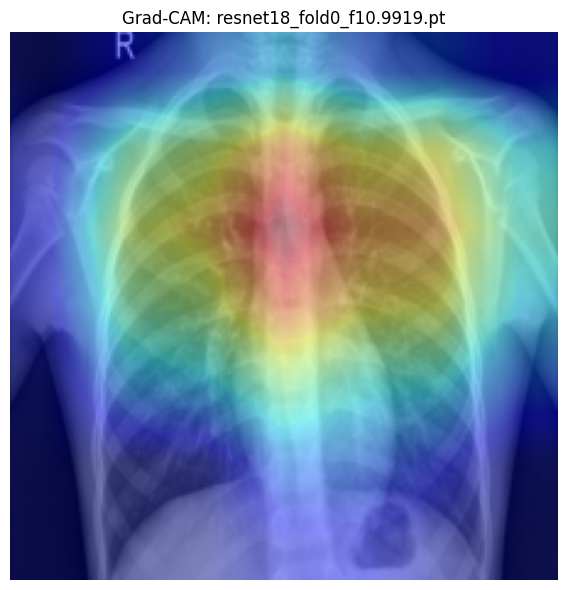

In [15]:
# Plot 
for path in unique_models:
    print(f"\n🔍 Analyzing: {path}")

    if "resnet18" in path:
        model_name = "resnet18"
    elif "densenet121" in path:
        model_name = "densenet121"
    elif "efficientnet_b0" in path:
        model_name = "efficientnet_b0"
    else:
        raise ValueError(f"Cannot identify model architecture from path: {path}")
        
    # Load the model architecture and pretrained weights
    model = get_model(model_name)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()  # Set model to evaluation mode

    y_true, y_pred, y_probs = [], [], []  # Initialize lists for true labels, predictions, and predicted probabilities

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probability scores for positive class (class 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            # Predicted class labels
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    # Plot confusion matrix with true vs predicted labels
    plot_confusion_matrix(y_true, y_pred, class_names, title=f"Confusion Matrix: {path}")

    # Plot ROC curve using true labels and predicted probabilities
    plot_roc_curve(y_true, y_probs, title=f"ROC Curve: {path}")

    # Select a single sample image and label from test set for Grad-CAM
    sample_img, sample_label = next(iter(test_loader))
    sample_img = sample_img[0].to(device)  # Select first sample image tensor
    sample_label = sample_label[0].item()  # Select first sample label

    # Determine final convolutional layer for Grad-CAM based on model type
    final_conv_layer = None
    if model_name == "resnet18":
        final_conv_layer = model.layer4[1].conv2
    elif model_name == "densenet121":
        final_conv_layer = model.features[-1]
    elif model_name == "efficientnet_b0":
        final_conv_layer = model.features[-1]

    # Generate Grad-CAM heatmap and predicted class for the sample image
    cam, pred_class = generate_gradcam(model, sample_img, sample_label, final_conv_layer)

    # Visualize Grad-CAM overlay on the sample image
    visualize_gradcam(sample_img, cam, title=f"Grad-CAM: {path}")

#### Performance Metrics — Confusion Matrix & ROC Curve


##### **Confusion Matrix (Prediction Breakdown)**

The confusion matrix provides a clear snapshot of how well the model distinguishes between **NORMAL** and **PNEUMONIA** cases:

- **True Positives (TP):** 384 Pneumonia cases correctly detected — ✅ ideal outcome  
- **True Negatives (TN):** 185 Normal (healthy) cases correctly identified — ✅ ideal outcome  
- **False Positives (FP):** 49 Normal cases wrongly flagged as pneumonia — ⚠️ may cause unnecessary concern  
- **False Negatives (FN):** 6 Pneumonia cases missed by the model — ❗critical to minimize

>  **Why this matters:**  
Missing a pneumonia diagnosis (false negative) is much more dangerous than a false positive. While false positives might lead to additional testing, false negatives can delay essential treatment. Fortunately, this model shows a **low false negative count**, which is encouraging in a clinical context.


##### **ROC Curve & AUC (Discrimination Power)**

The **ROC (Receiver Operating Characteristic) curve** visualizes how well the model balances between:

- **True Positive Rate** (Sensitivity): Correctly identifying pneumonia  
- **False Positive Rate**: Mistakenly flagging healthy cases

The **AUC (Area Under the Curve)** summarizes this balance:

- **AUC = 0.98** → Excellent ability to separate NORMAL vs. PNEUMONIA  
- **AUC ≈ 1.0** = perfect separation  
- **AUC ≈ 0.5** = no better than chance

> ✅ A high AUC confirms the model is learning **meaningful, generalizable features** to distinguish between classes — a strong indicator of real-world readiness.


**Key Takeaway:**  
The model performs strongly across all key metrics — low false negatives, a high AUC, and consistent behavior across cases. These are critical traits for building **trustworthy medical AI tools**.


#### Grad-CAM Interpretability Analysis

Grad-CAM (Gradient-weighted Class Activation Mapping) provides a visual explanation of the model’s decision-making process by highlighting the regions of the chest X-ray that contribute most to the classification. The following interpretation is based on the heatmap generated by `resnet18_fold0_f10.9919.pt`.

**High Activation Regions**  
The model demonstrates pronounced activation along the **central thoracic region**, particularly in the **mediastinum** and extending into the **middle lung zones**. This area is highlighted in red and yellow, suggesting the model is attending to structures commonly associated with pulmonary pathology, including vascular congestion or inflammatory infiltrates.

**Clinical Relevance**  
The highlighted regions correspond to **lung fields** rather than extraneous anatomical structures. Importantly, the model appears to focus on **central pulmonary tissue**, which can be indicative of pneumonia-related opacities, especially in the case of bilateral or centrally-located infections.

**Contextual Awareness**  
Grad-CAM reveals a balanced distribution of attention across both lungs. This bilateral focus is important for differential diagnosis, as pneumonia may present unilaterally or diffusely, and clinical assessment often involves comparing both lung fields.

**Absence of Spurious Focus**  
There is no substantial activation in irrelevant areas such as:
- The clavicles or shoulders
- The gastric bubble
- Corners or non-anatomical image regions

This absence of distraction indicates that the model’s attention remains confined to clinically meaningful zones.

**Summary of Insights**  
- The model concentrates on **relevant pulmonary structures**, particularly in the central and middle lung zones.
- Grad-CAM supports that the model is identifying **medically significant features** rather than overfitting to non-diagnostic cues.


---

## ***Final Analysis and Conclusion***

### Clinical Relevance

Pneumonia remains a significant global health challenge—particularly among high-risk populations such as young children, older adults, and immunocompromised individuals. Timely and accurate detection using chest radiographs is essential for guiding early intervention and improving clinical outcomes.

This project demonstrates how deep learning models, when combined with interpretability techniques like **Grad-CAM**, can enhance clinical workflows by:

- **Automatically identifying** radiographic patterns associated with pneumonia,
- **Highlighting diagnostically relevant regions** to support radiologist assessment,
- **Promoting transparency** in AI-driven predictions through heatmap explanations,


By aligning predictive performance with clinical reasoning, this work represents a meaningful step toward the safe and trustworthy deployment of AI systems in diagnostic radiology.


### Conclusion

This project successfully developed and validated an ensemble of advanced convolutional neural networks—**ResNet18**, **DenseNet121**, and **EfficientNet-B0**—to detect pneumonia in chest X-ray images.

Using a **stratified K-Fold cross-validation strategy**, **early stopping**, and **Grad-CAM-based interpretability**, each model was evaluated on a held-out test set (**n = 624**) to assess predictive performance and clinical applicability.

✅ **Top-performing model:**  
- **ResNet18 (Fold 0)** achieved **91.2% accuracy** and an **F1-score of 0.9332**, offering a strong balance between precision and recall.

📊 **Performance Summary:**
- F1-scores across all folds ranged from **0.8050 to 0.9332**
- All models consistently achieved **high pneumonia recall** (up to 100%), supporting their use in early triage

**Strengths of the Approach:**
- **ResNet18** demonstrated peak performance, while **DenseNet121** and **EfficientNet-B0** showed consistent, reliable metrics across folds
- **High sensitivity to pneumonia** ensures low false negative risk—critical in clinical diagnosis
- Grad-CAM visualizations contributed to **model transparency** and enhanced trust in predictions

**Areas for Future Development:**
- Incorporate **larger, more heterogeneous validation cohorts** to evaluate robustness
- Test generalizability using **external clinical datasets** with real-world noise and artifacts
- Explore **cost-sensitive learning** techniques to further reduce false negatives
- Expand **error analysis** to understand edge cases and guide model refinement

> **Final Thoughts:**  
This work demonstrates that deep learning models, particularly when augmented with interpretability tools like Grad-CAM, can play a valuable role in pneumonia detection from chest X-rays. By aligning high diagnostic performance with visual reasoning, such models are well-positioned to serve as clinical decision support tools that enhance diagnostic accuracy and improve patient outcomes in high-stakes environments.



---

### Resources

- **Dataset**: [Chest X-ray Pneumonia Dataset (Kaggle)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
- **PyTorch Documentation**: [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)
- **Torchvision Pretrained Models**: [https://pytorch.org/vision/stable/models.html](https://pytorch.org/vision/stable/models.html)
- **sklearn Classification Report**: [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- **Grad-CAM: Visual Explanations from Deep Networks**: Selvaraju et al., 2017 — [https://arxiv.org/abs/1610.02391](https://arxiv.org/abs/1610.02391)
- **EfficientNet Architecture**: Tan & Le, 2019 — [https://arxiv.org/abs/1905.11946](https://arxiv.org/abs/1905.11946)
- **Cross-Validation Strategy**: [Stratified K-Fold in sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [17]:
### End

---
---

#### [Back to Zachary's Portfolio](https://zraup.github.io/Zachary-Raup/)  
#### [Zachary's LinkedIn](https://www.linkedin.com/in/zachary-raup-6280a3265)
